In [1]:
%pylab inline
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import theano.tensor as T
import theano
plt.style.use(['seaborn-talk'])
plt.rcParams["figure.figsize"] = (10,8)
print(pm.__version__)
print(theano.__version__)

Populating the interactive namespace from numpy and matplotlib


/home/deadhead/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.5
1.0.2


In [2]:
c_light ="#DCBCBC"
c_light_highlight ="#C79999"
c_mid ="#B97C7C"
c_mid_highlight ="#A25050"
c_dark ="#8F2727"
c_dark_highlight ="#7C0000"

In [3]:
generative_ensemble2 = pm.Model()

N = 1000
R = 1000

with generative_ensemble2:
    theta = pm.Beta(name="theta", alpha = 1, beta = 1)
    lambda_ = pm.HalfNormal(name="lambda", sd = 6.44787)
    y = pm.ZeroInflatedPoisson(name = "y", psi = theta, theta = lambda_, shape = (N,))

In [4]:
with generative_ensemble2:
    trace = pm.sample_prior_predictive(samples=R)

In [5]:
trace["theta"][:10]

array([0.93332145, 0.7714699 , 0.86558357, 0.86497487, 0.60348962,
       0.74533668, 0.72284839, 0.03031713, 0.79020511, 0.34467172])

In [6]:
trace["lambda"][:10]

array([11.79980369,  0.07890616,  7.9198449 ,  4.02674117,  0.64993403,
        1.55746614,  3.21968629,  2.54351671,  0.94194133,  1.09817687])

In [7]:
simu_ys = trace["y"]
simu_ys

array([[ 0,  0,  0, ...,  6,  0,  0],
       [ 0,  0,  0, ...,  5,  1, 11],
       [ 0,  0,  0, ...,  7,  3,  6],
       ...,
       [ 0,  0,  0, ...,  5,  3, 16],
       [ 0,  0,  0, ...,  5,  0,  6],
       [ 0,  0,  0, ...,  7,  1, 11]])

In [8]:
np.count_nonzero(simu_ys, axis=0).std()

285.0109788692358

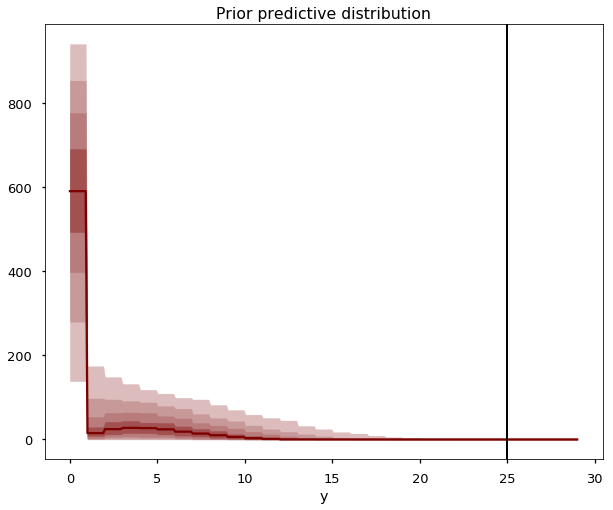

In [9]:
x_max = 30
bins = np.arange(0 ,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)

hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 1, simu_ys.T)

prctiles = np.percentile(hists,np.linspace(10, 90,num=9),axis=0)
prctiles_interp = np.repeat(prctiles, 10,axis=1)



for i, color in enumerate([c_light, c_light_highlight, c_mid, c_mid_highlight]):
    plt.fill_between(bin_interp, prctiles_interp[i, :],
                     prctiles_interp[-1 - i, :],
                     alpha = 1.0,
                     color = color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

In [10]:
simu_ys[simu_ys > 25].size / simu_ys.size

0.000609

## Fit Simulated Observations and Evaluate 

In [27]:
fit_data2 = pm.Model()

N = 1000
R = 1000

with fit_data2:
    theta = pm.Beta(name="theta", alpha = 1, beta = 1)
    lambda_ = pm.HalfNormal(name="lambda", sd = 6.44787)
    y = pm.ZeroInflatedPoisson(name = "y", 
                               psi = theta, 
                               theta = lambda_, 
                               shape = (N,),
                               observed=simu_ys[-1,:])

In [28]:
with fit_data2:
    trace_fit = pm.sample(R)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3320.34draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf6a29acc0>,
      dtype=object)

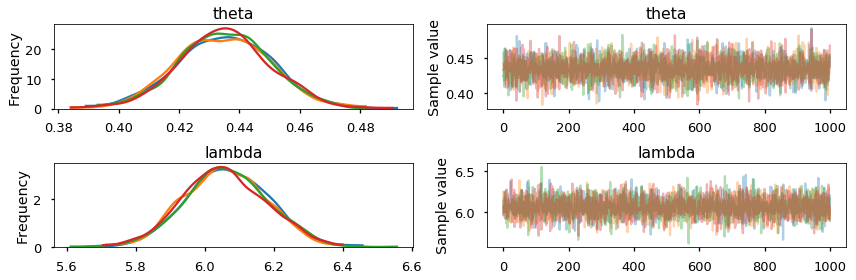

In [29]:
pm.plots.traceplot(trace_fit)

In [30]:
pm.summary(trace_fit, varnames=["theta", "lambda"]).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.43,0.02,0.0,0.41,0.46,4174.79,1.0
lambda,6.06,0.12,0.0,5.83,6.29,4191.15,1.0


In [20]:
import pickle
with open("fit_data2.pkl", "wb+") as buffer:
    pickle.dump({"model": fit_data2, "trace": trace_fit}, buffer)